# AMPSphere v.2022-03

This is a notebook meant to form the set of notebooks used to analyze the data in AMPSphere and write the manuscript:

**AMPSphere: Global survey of prokaryotic antimicrobial peptides shaping microbiomes**


## Analysis of the AMP density across different continents

The AMP density may vary across species, and samples. Moreover, the host-associated samples present more AMPs than the environmental ones. Interestingly, we observed strains from the human guts more dense than those from the oral cavity. Besides, we also observed that the host may influence the AMP density in a same species, such as *Prevotella copri*. Therefore, we tested the AMP density of microbial strains from human guts across different continents, which may be related to several abiotic factors, and would imply in a pattern at global level of how the lifestyle of different communities may impact in microbe shapping molecules.


In [1]:
import pandas as pd
import seaborn as sns

from itertools import combinations
from scipy.stats import mannwhitneyu
from matplotlib import pyplot as plt
from statsmodels.stats.multitest import multipletests

For convenience reasons, we used only the following continents: Europe, Asia, North America, South America, Australia, Africa. The corner cases were adjusted, such as the Central America, which was considered as North America and Oceania samples, which were included as from the australian continent.

In [2]:
continents = {'Finland': 'Europe',
              'Austria': 'Europe',
              'Netherlands': 'Europe',
              'France': 'Europe',
              'Denmark': 'Europe',
              'Switzerland': 'Europe',
              'Canada': 'North America',
              'New Zealand': 'Australia',
              'Singapore': 'Asia',
              'Tanzania': 'Africa',
              'UK': 'Europe',
              'Australia': 'Australia',
              'Bangladesh': 'Asia',
              'Republic of the Congo': 'Africa',
              'Liberia': 'Africa',
              'USA': 'North America',
              'Israel': 'Asia',
              'Italy': 'Europe',
              'Estonia': 'Europe',
              'Brazil': 'South America',
              'Ireland': 'Europe',
              'China': 'Asia',
              'India': 'Asia',
              'Russia': 'Asia',
              'Sweden': 'Europe',
              'Mozambique': 'Africa',
              'Cameroon': 'Africa',
              'Fiji': 'Australia',
              'Madagascar': 'Africa',
              'Ghana': 'Africa',
              'Peru': 'South America',
              'Mongolia': 'Asia',
              'Ethiopia': 'Africa',
              'Germany': 'Europe',
              'Spain': 'Europe',
              'South Korea': 'Asia',
              'Japan': 'Asia',
              'El Salvador': 'North America',
              'Luxembourg': 'Europe',
              'Indonesia': 'Asia'}

In [3]:
# loading data
gmsc= pd.read_table('data/gmsc_amp_genes_envohr_source.tsv.gz')
samples = pd.read_table('data/samples-min500k-assembly-prodigal-stats.tsv.gz')
samples = samples.rename({'sample_accession':'sample'}, axis=1)

In [4]:
# filter data
gmsc = gmsc[(gmsc.general_envo_name == 'human gut') & (gmsc.is_metagenomic == True)]
gmsc = gmsc.groupby(['sample', 'geographic_location']).agg('size')
gmsc = gmsc.reset_index()

In [5]:
# calculate density
gmsc = gmsc.merge(on='sample', right=samples)
gmsc = gmsc.rename({0: 'amp_genes'}, axis=1)
gmsc = gmsc[['sample', 'geographic_location', 'amp_genes', 'assembly_total_length']]
gmsc['density'] = gmsc['amp_genes'] * 1e9 / gmsc['assembly_total_length']

In [6]:
# eliminate outliers
q1, q3 = gmsc.density.quantile([0.25, 0.75])
iqr = q3-q1
ul, ll = q3+(1.5*iqr), q1-(1.5*iqr)
gmsc_filtered = gmsc[(gmsc.density <= ul) & (gmsc.density >= ll)]

In [7]:
gmsc_filtered['continent'] = gmsc_filtered.geographic_location.map(lambda x: continents.get(x))
combs = combinations(set(gmsc_filtered.continent), 2)

/tmp/ipykernel_861206/574769344.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gmsc_filtered['continent'] = gmsc_filtered.geographic_location.map(lambda x: continents.get(x))


In [8]:
hs = []
for i, j in combs:
    u, p = mannwhitneyu(gmsc_filtered.loc[gmsc_filtered.continent == i, 'density'],
                        gmsc_filtered.loc[gmsc_filtered.continent == j, 'density'])
    hs.append((i, j, u, p))

# converting to a dataframe
hs = pd.DataFrame(hs, columns=['continent1', 'continent2', 'U', 'p'])

# correcting p-values
_, hs['p_adj'], _, _ = multipletests(hs['p'], method='hs')

# getting intuitions
hs['sig'] = hs.p_adj.map(lambda x: '*' if x < 0.05 else 'n.s.')

hs

,continent1,continent2,U,p,p_adj,sig
0,Europe,Australia,7893346.0,4.452491e-23,4.007242e-22,*
1,Europe,Asia,37636872.0,1.324110e-46,1.456521e-45,*
2,Europe,North America,51810545.0,2.870518e-18,2.296414e-17,*
3,Europe,South America,338258.0,5.163841e-01,6.205628e-01,n.s.
4,Europe,Africa,3467928.0,6.945936e-52,8.335123e-51,*
5,Australia,Asia,4941357.0,2.776956e-60,3.610042e-59,*
6,Australia,North America,7025306.0,3.120565e-06,1.560273e-05,*
7,Australia,South America,45541.0,7.980463e-03,3.154176e-02,*
8,Australia,Africa,474191.0,9.515400e-13,6.660780e-12,*
9,Asia,North America,56180375.0,3.883267e-98,5.824901e-97,*


In [9]:
# defining plot order by the Q50
order = gmsc_filtered.groupby('continent')
order = order['density'].quantile(0.5)
order = order.sort_values()
order = order.index

In [10]:
# sample a small number of dots to the plot
sampled_gmsc_filtered = gmsc_filtered.groupby('continent')
sampled_gmsc_filtered = sampled_gmsc_filtered.apply(lambda x: x.sample(75))

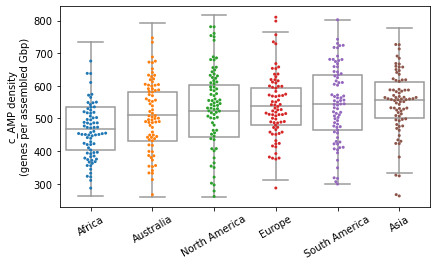

In [13]:
sns.boxplot(data=gmsc_filtered,
            x='continent',
            y='density',
            showfliers=False,
            color='white',
            order=order)

sns.swarmplot(data=sampled_gmsc_filtered,
              x='continent',
              y='density',
              s=3,
              order=order)

plt.xticks(rotation=30)
plt.tight_layout()
plt.xlabel('')
plt.ylabel('c_AMP density\n(genes per assembled Gbp)')
plt.savefig('continents_human_guts.svg')

In [14]:
# exporting results
hs.to_csv('continents_amp_density_human_guts.tsv.gz', sep='\t', header=True, index=None)